In [21]:
from zget_data import get_responses, get_qdetails, get_qinfo, get_questions, page_map, quest_map
from collections import defaultdict
import pandas as pd
import json
import matplotlib.pyplot as plt

In [22]:
survey_response, time_response = get_responses()

# Time Analysis

,index,1,2,3,4,5,6,7,csquest,spasssurvey,demo,total (mins)
0,120.245,10.795,2.944,52.429,2.536,79.314,2.014,8.447,611.214,88.296,163.980,19.036900
1,47.704,8.317,5.774,20.529,3.303,35.736,6.323,62.769,1143.746,75.336,75.957,24.758233
2,143.658,1.874,2.321,32.339,2.939,62.756,1.522,10.638,740.547,110.914,183.715,21.553717
3,76.810,12.427,3.682,68.276,1.900,20.256,2.040,29.766,690.050,80.177,104.345,18.162150
4,8.529,3.295,2.195,72.718,4.212,17.386,2.465,25.687,696.829,80.177,122.039,17.258867
5,85.519,19.173,3.417,93.238,3.750,14.827,2.250,20.808,906.945,161.671,176.944,24.809033
6,121.899,6.936,19.950,143.431,5.255,22.239,5.637,31.740,1094.535,132.327,250.360,30.571817
7,46.771,12.130,4.182,102.546,5.296,64.259,3.211,9.071,773.980,353.297,110.543,24.754767
8,1045.632,11.014,2.314,39.932,3.100,51.831,2.446,8.913,591.729,127.113,186.811,34.513917
9,38.344,10.710,1.995,51.858,6.528,78.176,3.677,14.460,497.517,34.668,90.051,13.799733


27.26275344827586

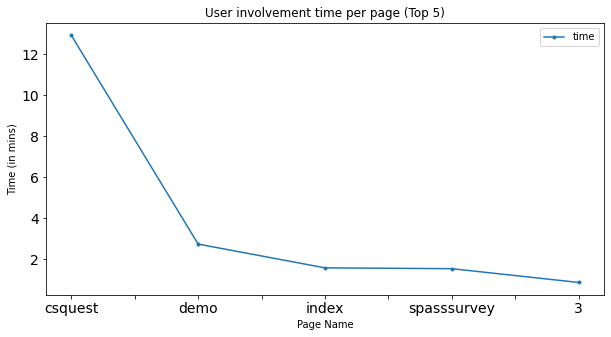

In [23]:
page_time_df = pd.DataFrame(time_response)
page_time_df = page_time_df.sort_index(axis=1, key=lambda x: x.astype(int))
page_time_df = page_time_df.rename(page_map, axis=1)
page_time_df['total (mins)'] = page_time_df.sum(axis=1)/60
display(page_time_df)
display(page_time_df['total (mins)'].mean())


# top 5 pages with higher time
top5 = pd.DataFrame(columns=['page', 'time'])
for i, data in page_time_df.median().div(60).sort_values(ascending=False).head(5).items():
    top5 = pd.concat([top5, pd.DataFrame([[i, data]], columns=top5.columns)])

_ = top5.plot(x='page', y='time', figsize=(10, 5), xlabel="Page Name", ylabel="Time (in mins)", title="User involvement time per page (Top 5)", fontsize=14, style=".-")

# Survey Response Analysis

In [24]:
questions = get_questions()
survey_response_df = pd.DataFrame(survey_response)
display(survey_response_df.head(1))

,8,10,9,0,null
0,"{'Cus': {'9-1': '7', '10-1': '6', '11-1': 'The...","{'1-1': 'Girl', '2-1': '11 years old', '3-1': ...","{'1-1': 'grandmabiking7years', '2-1': 'Strong'...","{'1-1': ['Schoolwork', 'Entertainment (for exa...",NaN


In [25]:
# Function to filter data based on page number
def test(d):
    temp = {}
    for k, v in d.items():
        if (k != 'design_order'):
            for k2, v2 in v.items():
                q = f'{k2}_{k}'
                temp[q] = v2
    return temp

## CSQuest

In [26]:
csq_pid = '8'
design_order_series = survey_response_df[csq_pid].apply(lambda x: x.get('design_order'))
csquest_response_df = survey_response_df[csq_pid].apply(test)
csquest_questions = get_questions().get(csq_pid)

csquest_response_df = pd.DataFrame(csquest_response_df.to_dict()).T
csquest_response_df.head(1)

,9-1_Cus,10-1_Cus,11-1_Cus,1-4_Cus,1-2_Cus,1-1_Cus,1-3_Cus,6-1_Cus,7-1_Cus,8-1_Cus,...,6-1_Bas,7-1_Bas,13-1_Bas,4-1_Bas,8-1_Bas,11-1_Bas,4-1_Sto,8-1_Sto,13-1_Sto,11-1_Sto
0,7,6,The third one because it showed both the steps...,6,5,5,6,1,5,The second one because it showed what could ha...,...,2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
qualqsid = ['4-1', '8-1', '11-1', '12-1', '13-1']
quantqsid = ['1-1', '1-2', '1-3', '1-4', '2-1', '3-1', '5-1', '5-2', '5-3', '5-4', '6-1', '7-1', '9-1', '10-1']
dnames = ['Sto', 'Cus', 'Bas']

qualcolumns = [f'{qsid}_{dname}' for qsid in qualqsid for dname in dnames]
quantcolumns = [f'{qsid}_{dname}' for qsid in quantqsid for dname in dnames]

### Qualitative Analysis/Export

In [28]:
qualcolumns_filtered = list(set(csquest_response_df.columns).intersection(qualcolumns))
csquest_qual_df = csquest_response_df[qualcolumns_filtered]

In [29]:
prefixes = set(col.split('_')[0] for col in csquest_qual_df.columns)

# Combine columns based on the common prefixes
for prefix in prefixes:
    matching_columns = [col for col in csquest_qual_df.columns if col.startswith(prefix)]
    combined_column_name = prefix.split('-')[0]
    csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    csquest_qual_df = csquest_qual_df.drop(columns=matching_columns)

# Function to remove nan_ from the beginning and _nan from the end
def remove_prefix_suffix(value):
    if pd.notna(value):
        value = str(value)
        if value.startswith('nan_'):
            value = value[4:]
        if value.endswith('_nan'):
            value = value[:-4]
    return value

# Apply the function to each element in the DataFrame
csquest_qual_df = csquest_qual_df.applymap(remove_prefix_suffix)

new_columns = [get_qinfo(csq_pid, c) for c in csquest_qual_df.columns]
csquest_qual_df.columns = new_columns
csquest_qual_df['Design Order'] = design_order_series
csquest_qual_df.to_csv('data/qualitative/csquest.csv', index=False)

<ipython-input-29-9a593187a795>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


### Quantitative Analysis

In [30]:
csquest_quant_df = csquest_response_df[quantcolumns].astype(int)
norm_csquest_quant_df = csquest_quant_df.sub(4)
norm_csquest_quant_df.head(1)

,1-1_Sto,1-1_Cus,1-1_Bas,1-2_Sto,1-2_Cus,1-2_Bas,1-3_Sto,1-3_Cus,1-3_Bas,1-4_Sto,...,6-1_Bas,7-1_Sto,7-1_Cus,7-1_Bas,9-1_Sto,9-1_Cus,9-1_Bas,10-1_Sto,10-1_Cus,10-1_Bas
0,1,1,2,0,1,3,2,2,3,1,...,-2,1,1,3,2,3,3,2,2,3


In [31]:
norm_sto_df = norm_csquest_quant_df.filter(like='Sto')
norm_cus_df = norm_csquest_quant_df.filter(like='Cus')
norm_bas_df = norm_csquest_quant_df.filter(like='Bas')

In [44]:
condition = '1-|5-'
new_norm_sto_df = norm_sto_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

temp = norm_sto_df.filter(like='1-')
new_norm_sto_df['1'] = temp.T.mean()

temp = norm_sto_df.filter(like='5-')
new_norm_sto_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

display(new_norm_sto_df)


condition = '1-|5-'
new_norm_cus_df = norm_cus_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

temp = norm_cus_df.filter(like='1-')
new_norm_cus_df['1'] = temp.T.mean()

temp = norm_cus_df.filter(like='5-')
new_norm_cus_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

display(new_norm_cus_df)


condition = '1-|5-'
new_norm_bas_df = norm_bas_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

temp = norm_bas_df.filter(like='1-')
new_norm_bas_df['1'] = temp.T.mean()

temp = norm_bas_df.filter(like='5-')
new_norm_bas_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

display(new_norm_bas_df)
# display(new_norm_bas_df.avg())

# test = new_norm_bas_df.mean(axis=0)
# display(test)



,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,1,1,3,1,2,2,1.00,1.75
1,0,1,1,3,1,3,1.25,2.00
2,2,2,3,3,3,3,2.00,2.25
3,0,0,1,0,2,1,0.25,0.00
4,1,2,2,2,3,2,0.50,2.50
5,2,1,2,2,3,1,1.25,1.75
6,3,3,3,3,3,2,3.00,2.75
7,2,2,2,3,3,2,0.00,2.00
8,2,3,2,3,2,2,1.25,3.00
9,0,0,0,1,0,1,-1.75,1.00


,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,2,2,-3,1,3,2,1.50,2.50
1,1,0,1,3,1,3,0.75,2.00
2,2,3,2,3,3,3,2.50,2.75
3,0,0,0,0,0,0,-0.25,-0.25
4,2,1,2,2,2,2,1.75,2.75
5,2,2,1,2,2,2,1.50,2.00
6,2,3,3,3,3,3,2.75,2.75
7,2,2,1,1,3,2,3.00,1.75
8,1,2,0,2,3,3,1.50,2.75
9,0,1,0,1,1,2,-0.25,1.50


,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,3,3,-2,3,3,3,2.50,3.00
1,0,1,1,3,1,3,1.50,2.00
2,2,3,2,2,3,3,2.50,3.00
3,-1,0,0,0,1,0,-0.25,0.00
4,2,1,3,3,3,3,1.00,2.75
5,1,0,1,3,2,3,0.75,2.50
6,2,3,3,3,3,3,2.75,2.75
7,2,2,1,1,3,2,1.00,2.00
8,1,2,1,2,2,3,1.50,2.75
9,1,0,2,2,2,0,0.50,0.50


In [33]:
def stats(df, title='Main Title'):
    # Set up subplots
    fig, axes = plt.subplots(nrows=len(df.select_dtypes(include='number').columns), ncols=4, figsize=(15, 2 * len(df.columns)))
    # Loop through numerical columns and plot distribution in subplots
    for i, column in enumerate(df.select_dtypes(include='number').columns):
        # Descriptive statistics
        axes[i, 0].set_title(f'Statistics of {column}')
        stats = df[column].describe()
        pd.DataFrame(stats).T.plot.box(ax=axes[i, 0])
        # Rotate x-axis labels at a 45-degree angle
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=45, ha='right')
        # print(f'Distribution for column {column}:\n{stats}\n')
        # stats.T.plot.box(vert=False)
        
        # Plot histogram
        df[column].plot(kind='hist', bins=10, edgecolor='black', ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram of {column}')
        axes[i, 1].set_xlabel(column)
        axes[i, 1].set_ylabel('Frequency')
        
        # Box plot
        df.boxplot(column=column, ax=axes[i, 2])
        axes[i, 2].set_title(f'Box Plot of {column}')
        
        # KDE plot
        df[column].plot(kind='kde', ax=axes[i, 3])
        axes[i, 3].set_title(f'KDE Plot of {column}')

    # Adjust layout
    plt.tight_layout()
    
    # Add a title at the top of the figure with some margin below
    # plt.suptitle(title, y=0.95, fontsize=16)
    plt.show()

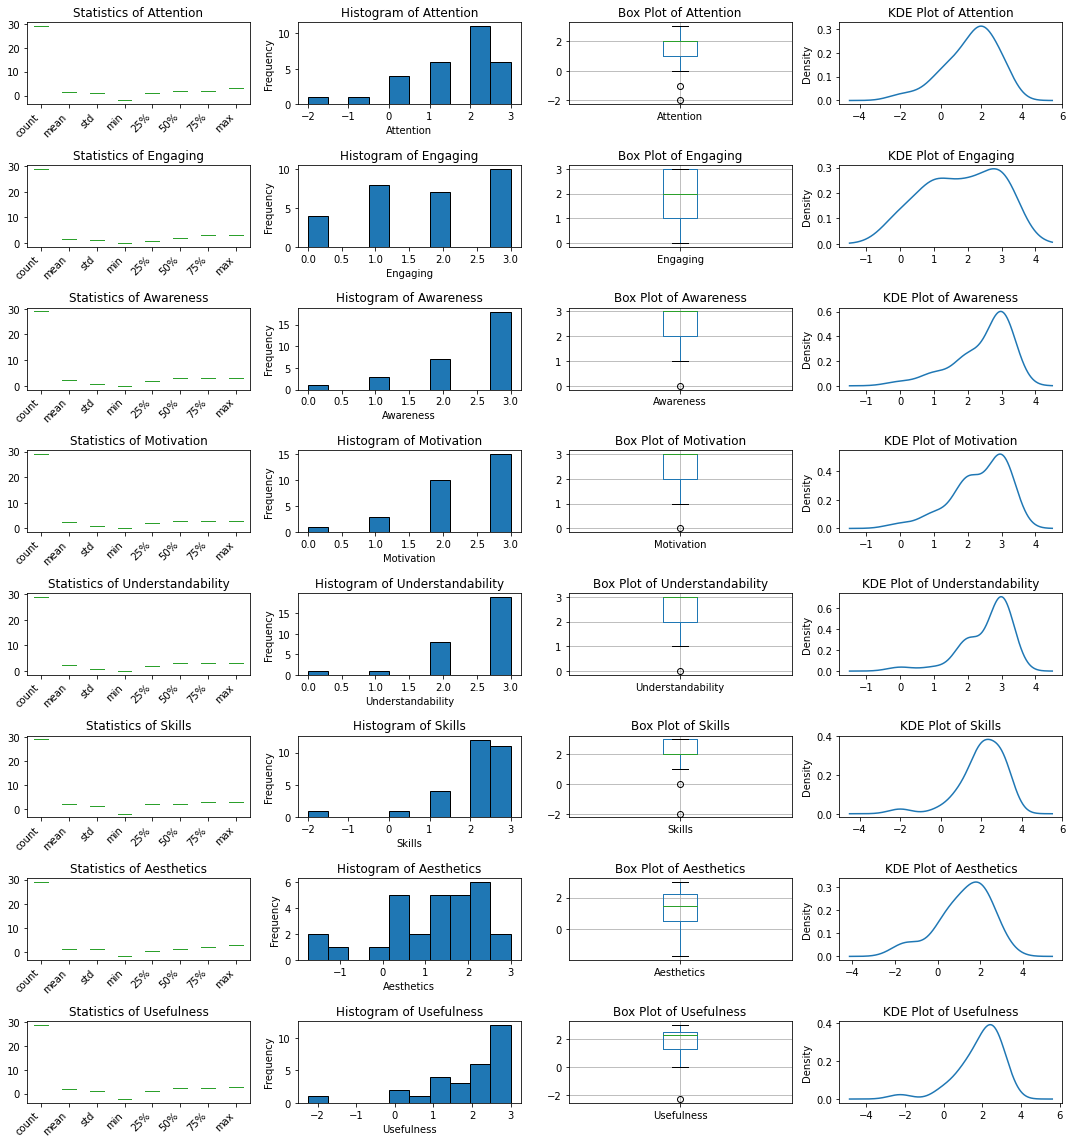

In [34]:
stats(new_norm_sto_df, 'Story')

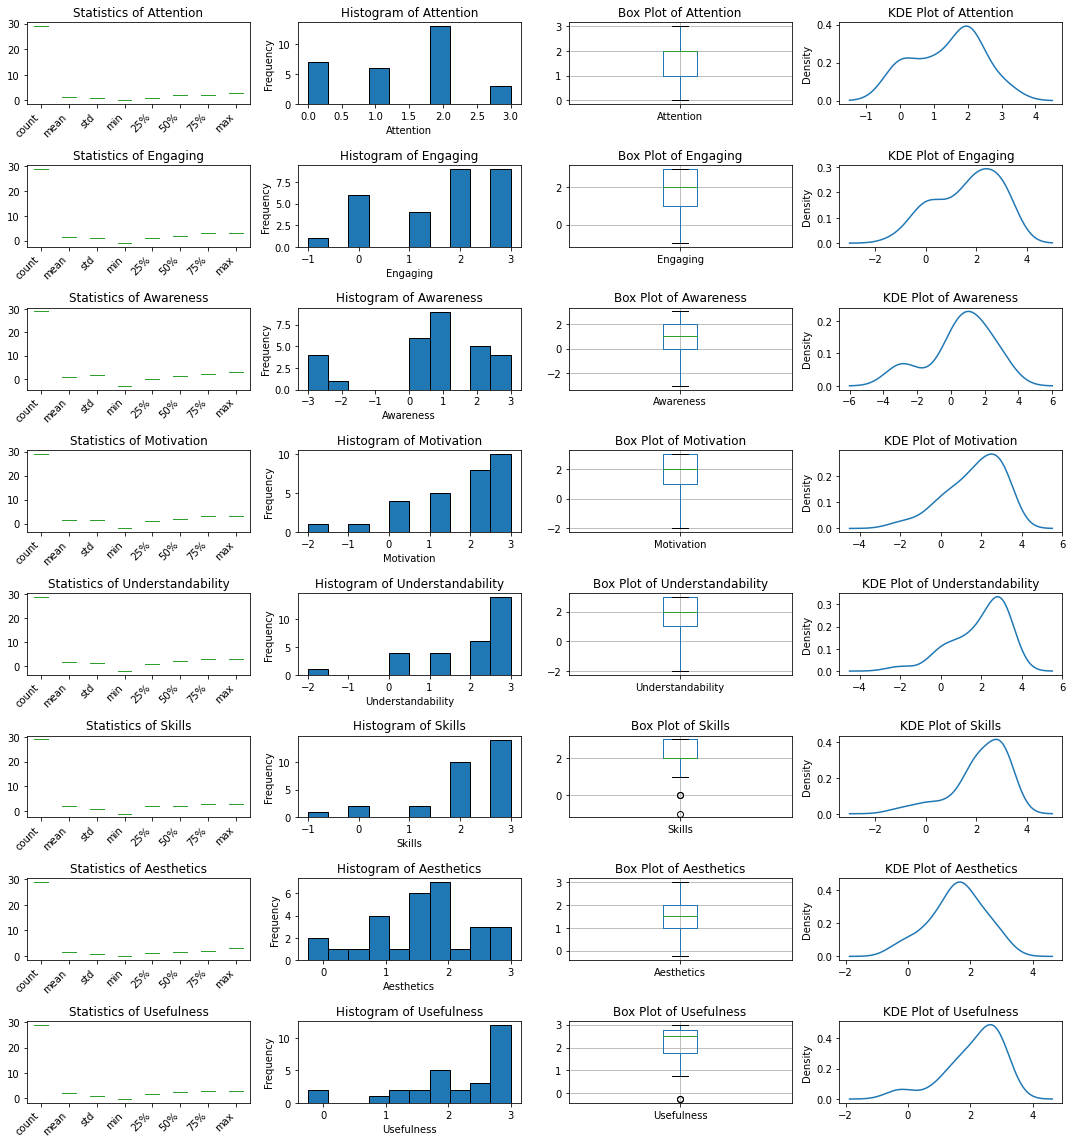

In [35]:
stats(new_norm_cus_df, 'Custom')

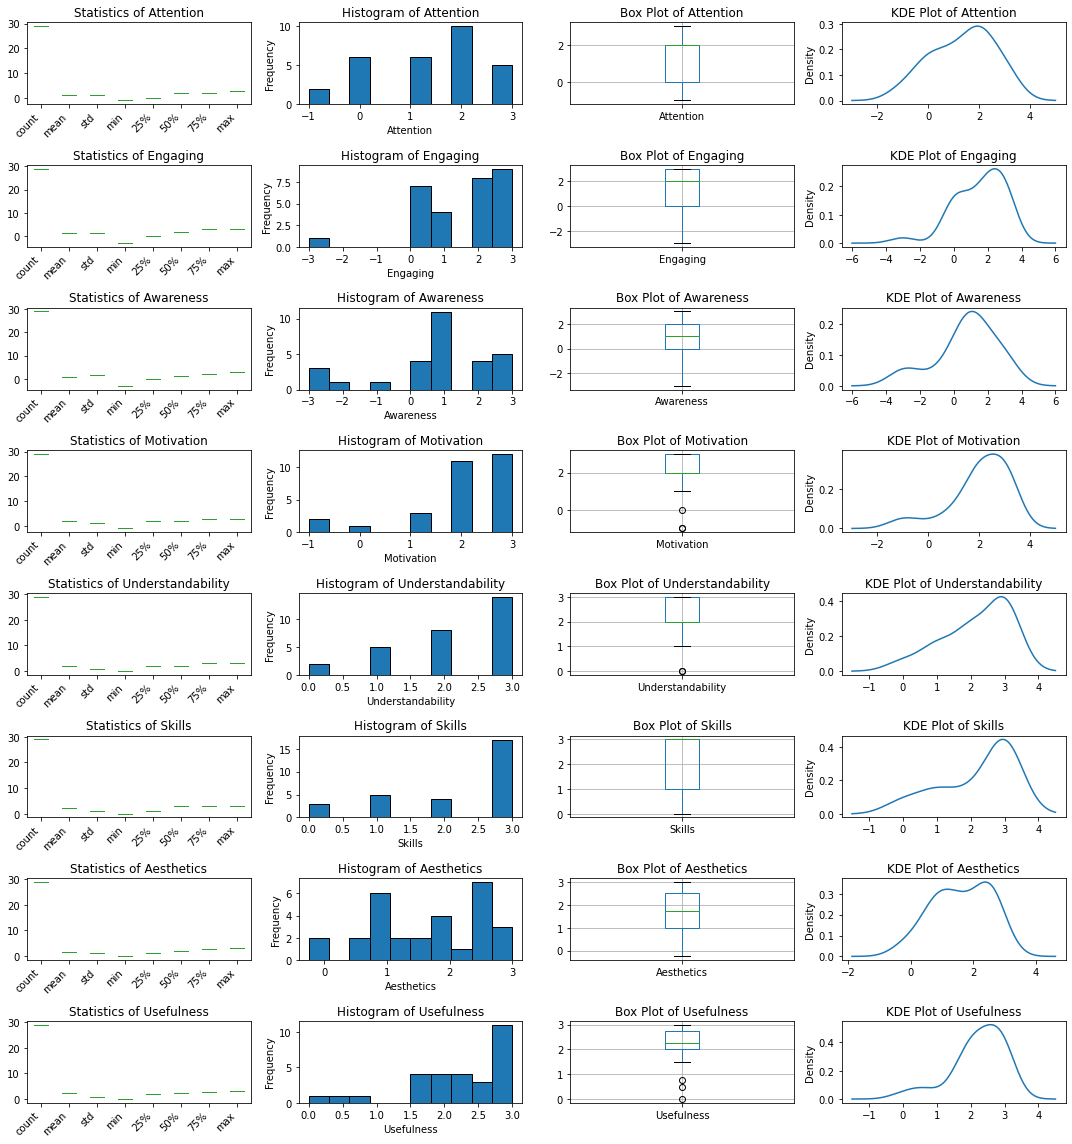

In [36]:
stats(new_norm_bas_df, 'Baseline')

In [37]:
sto_mean = pd.DataFrame(new_norm_sto_df.mean()).T
cus_mean = pd.DataFrame(new_norm_cus_df.mean()).T
bas_mean = pd.DataFrame(new_norm_bas_df.mean()).T

NameError: name 'y_value' is not defined

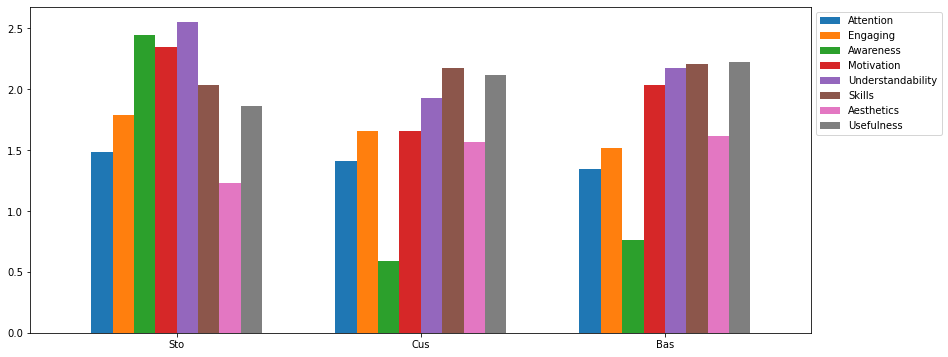

In [38]:
combined_df = pd.concat([sto_mean, cus_mean, bas_mean], ignore_index=True)
ax = combined_df.plot.bar(width=0.7, figsize=(14, 6))
_ = ax.set_xticklabels(dnames, rotation=0)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# _ = ax.annotate((y_value, "x_position" , "y_position"))